In [1]:
import os

dataset_path = "/kaggle/input/swir-products-merged2/swir_products_merged2"
train_images_path = os.path.join(dataset_path, "images/train")
train_masks_path = os.path.join(dataset_path, "annotations/train")

dataset_path_test = "/kaggle/input/swir-products-merged2/swir_products_merged2"
test_images_path = os.path.join(dataset_path_test, "images/test")
test_masks_path = os.path.join(dataset_path_test, "annotations/test")

print("Train Images:", len(os.listdir(train_images_path)))
print("Train Masks:", len(os.listdir(train_masks_path)))
print("Test Images:", len(os.listdir(test_images_path)))
print("Test Masks:", len(os.listdir(test_masks_path)))

print("\n–ü—Ä–∏–º–µ—Ä—ã —Ñ–∞–π–ª–æ–≤ (Train Images):", os.listdir(train_images_path)[:5])
print("–ü—Ä–∏–º–µ—Ä—ã —Ñ–∞–π–ª–æ–≤ (Train Masks):", os.listdir(train_masks_path)[:5])


Train Images: 678
Train Masks: 226
Test Images: 108
Test Masks: 36

–ü—Ä–∏–º–µ—Ä—ã —Ñ–∞–π–ª–æ–≤ (Train Images): ['349_1050.jpg', '122_800.jpg', '345_1050.jpg', '072_800.jpg', '107_800.jpg']
–ü—Ä–∏–º–µ—Ä—ã —Ñ–∞–π–ª–æ–≤ (Train Masks): ['173.png', '248.png', '038.png', '069.png', '340.png']


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as T


class MultiChannelSingleMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, wavelengths=(800, 1050, 1550), transform=None, img_size=512):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.wavelengths = wavelengths
        self.transform = transform
        self.img_size = img_size

        # –°–æ–±–∏—Ä–∞–µ–º –≤—Å–µ —Ñ–∞–π–ª—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ –∏–∑–≤–ª–µ–∫–∞–µ–º —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ ID
        all_files = os.listdir(images_dir)
        
        # –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ —Ç–µ —Ñ–∞–π–ª—ã, –∫–æ—Ç–æ—Ä—ã–µ —è–≤–ª—è—é—Ç—Å—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏
        image_ids = sorted(set(f.split('_')[0] for f in all_files if f.endswith(".jpg")))

        # –ü—Ä–æ–≤–µ—Ä–∫–∞, –µ—Å–ª–∏ –Ω–µ—Ç —Ñ–∞–π–ª–æ–≤, —Ç–æ –≤—ã–≤–æ–¥–∏–º –æ—à–∏–±–∫—É
        if not image_ids:
            print(f"–ù–µ—Ç —Ñ–∞–π–ª–æ–≤ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –≤ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏: {images_dir}")
        else:
            print(f"–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {image_ids}")

        # –ü–æ–¥–≥–æ—Ç–æ–≤–∏–º —Å–ø–∏—Å–æ–∫ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
        self.image_ids = image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # –ó–∞–≥—Ä—É–∂–∞–µ–º 3 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø–æ –¥–ª–∏–Ω–∞–º –≤–æ–ª–Ω
        image = []
        for wl in self.wavelengths:
            image_path = os.path.join(self.images_dir, f"{image_id}_{wl}.jpg")
            if not os.path.exists(image_path):
                print(f"–ò–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ: {image_path}")
                continue  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º —Ñ–∞–π–ª, –µ—Å–ª–∏ –µ–≥–æ –Ω–µ—Ç
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype(np.float32) / 255.0
            image.append(img)
        
        # –ï—Å–ª–∏ –Ω–µ –≤—Å–µ –∫–∞–Ω–∞–ª—ã –∑–∞–≥—Ä—É–∂–µ–Ω—ã, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º —ç—Ç–æ—Ç ID
        if len(image) != len(self.wavelengths):
            print(f"–û—à–∏–±–∫–∞: –Ω–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –≤—Å–µ –∫–∞–Ω–∞–ª—ã –¥–ª—è ID {image_id}")
            return None  # –ï—Å–ª–∏ –Ω–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –≤—Å–µ –∫–∞–Ω–∞–ª—ã, –≤–æ–∑–≤—Ä–∞—â–∞–µ–º None

        image = np.stack(image, axis=-1)  # [H, W, 3]

        # –ó–∞–≥—Ä—É–∂–∞–µ–º –º–∞—Å–∫—É (–æ–¥–Ω—É –¥–ª—è –≤—Å–µ—Ö)
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")
        if not os.path.exists(mask_path):
            print(f"–ú–∞—Å–∫–∞ –Ω–µ –Ω–∞–π–¥–µ–Ω–∞: {mask_path}")
            return None  # –ï—Å–ª–∏ –º–∞—Å–∫–∞ –Ω–µ –Ω–∞–π–¥–µ–Ω–∞, –≤–æ–∑–≤—Ä–∞—â–∞–µ–º None
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        
        # –†–µ—Å–∞–π–∑ –º–∞—Å–∫–∏ –¥–æ 512x512
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # –ü—Ä–∏–º–µ–Ω—è–µ–º –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏, –µ—Å–ª–∏ –µ—Å—Ç—å
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        # –í PyTorch: [C, H, W]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # [3, H, W]
        mask = torch.tensor(mask, dtype=torch.long)  # [H, W], –≥–¥–µ 0 ‚Äî —Ñ–æ–Ω, 1 ‚Äî –¥–µ—Ñ–µ–∫—Ç

        return image, mask




train_dataset = MultiChannelSingleMaskDataset(train_images_path, train_masks_path, img_size=512)

# –ü—Ä–æ–±—É–µ–º –≤–∑—è—Ç—å –ø–µ—Ä–≤—ã–π —ç–ª–µ–º–µ–Ω—Ç:
sample_img, sample_mask = train_dataset[0]

if sample_img is not None and sample_mask is not None:
    print(f"–§–æ—Ä–º–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: {sample_img.shape}")  # [3, 512, 512]
    print(f"–§–æ—Ä–º–∞ –º–∞—Å–∫–∏: {sample_mask.shape}")        # [512, 512]
    print(f"–ö–ª–∞—Å—Å—ã –≤ –º–∞—Å–∫–µ: {torch.unique(sample_mask)}")
else:
    print("–û—à–∏–±–∫–∞ –ø—Ä–∏ –∑–∞–≥—Ä—É–∑–∫–µ –¥–∞–Ω–Ω—ã—Ö")


–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: ['034', '035', '036', '037', '038', '044', '047', '048', '049', '050', '051', '053', '054', '055', '056', '057', '058', '059', '060', '061', '063', '064', '065', '068', '069', '070', '072', '073', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '086', '087', '088', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '114', '115', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '131', '132', '133', '134', '136', '137', '138', '139', '141', '142', '143', '144', '145', '146', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '166', '167', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', 

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: 226
–§–æ—Ä–º–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: torch.Size([3, 512, 512])
–§–æ—Ä–º–∞ –º–∞—Å–∫–∏: torch.Size([512, 512])
–ö–ª–∞—Å—Å—ã –≤ –º–∞—Å–∫–µ: tensor([0, 1])


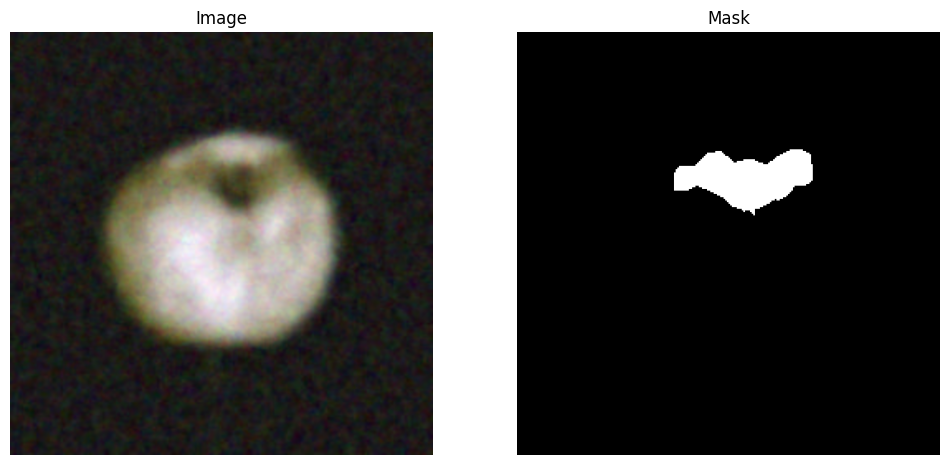

In [3]:
# 1. –ü—Ä–æ–≤–µ—Ä–∏–º –¥–ª–∏–Ω—É –¥–∞—Ç–∞—Å–µ—Ç–∞
print(f"–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: {len(train_dataset)}")

# 2. –ü–æ–ø—Ä–æ–±—É–µ–º –∑–∞–≥—Ä—É–∑–∏—Ç—å –∏ –≤—ã–≤–µ—Å—Ç–∏ –ø–µ—Ä–≤–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏ –µ–≥–æ –º–∞—Å–∫—É
sample_img, sample_mask = train_dataset[217]

# –ü—Ä–æ–≤–µ—Ä–∏–º, —á—Ç–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏ –º–∞—Å–∫–∞ –∑–∞–≥—Ä—É–∂–µ–Ω—ã
if sample_img is not None and sample_mask is not None:
    print(f"–§–æ—Ä–º–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è: {sample_img.shape}")  # –û–∂–∏–¥–∞–µ–º [3, 512, 512]
    print(f"–§–æ—Ä–º–∞ –º–∞—Å–∫–∏: {sample_mask.shape}")        # –û–∂–∏–¥–∞–µ–º [512, 512]
    print(f"–ö–ª–∞—Å—Å—ã –≤ –º–∞—Å–∫–µ: {torch.unique(sample_mask)}")
else:
    print("–û—à–∏–±–∫–∞ –ø—Ä–∏ –∑–∞–≥—Ä—É–∑–∫–µ –¥–∞–Ω–Ω—ã—Ö")

# 3. –î–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ –æ–¥–Ω–æ–≥–æ –ø—Ä–∏–º–µ—Ä–∞
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    image = image.permute(1, 2, 0).numpy()  # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≤ [H, W, C]
    mask = mask.numpy()
    
    # –°–æ–∑–¥–∞–µ–º –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–∏ –¥–ª—è –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏ –º–∞—Å–∫–∏
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # –û—Ç–æ–±—Ä–∞–∂–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    # –û—Ç–æ–±—Ä–∞–∂–∞–µ–º –º–∞—Å–∫—É
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.show()

# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º –ø–µ—Ä–≤—ã–π –ø—Ä–∏–º–µ—Ä
if sample_img is not None and sample_mask is not None:
    show_image_and_mask(sample_img, sample_mask)


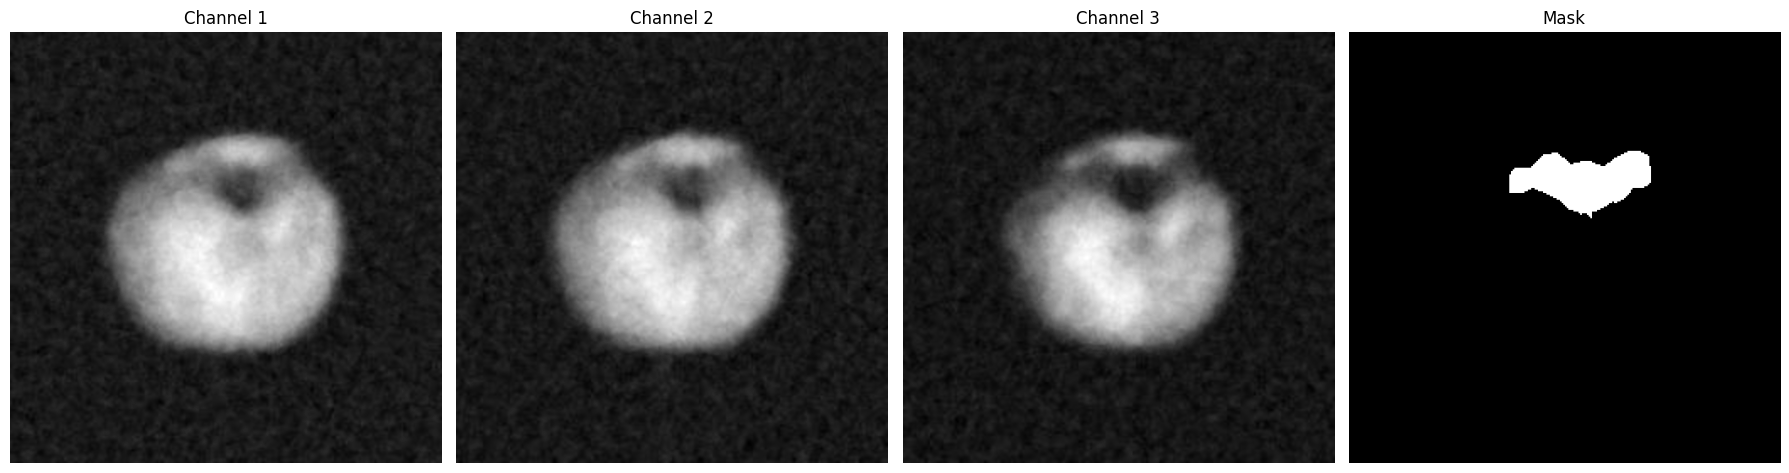

In [4]:
def show_individual_channels(image_tensor, mask_tensor):
    image = image_tensor.numpy()
    mask = mask_tensor.numpy()

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    for i in range(3):
        axes[i].imshow(image[i], cmap='gray')
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis('off')
    
    axes[3].imshow(mask, cmap='gray')
    axes[3].set_title("Mask")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è:
show_individual_channels(sample_img, sample_mask)


In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #, drop_last=True

batch_images, batch_masks = next(iter(train_loader))
print(f"–†–∞–∑–º–µ—Ä batch –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: {batch_images.shape}")  # [B, 3, 512, 512]
print(f"–†–∞–∑–º–µ—Ä batch –º–∞—Å–æ–∫: {batch_masks.shape}")        # [B, 512, 512]


–†–∞–∑–º–µ—Ä batch –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: torch.Size([8, 3, 512, 512])
–†–∞–∑–º–µ—Ä batch –º–∞—Å–æ–∫: torch.Size([8, 512, 512])


In [6]:
mask_files = sorted(os.listdir(train_masks_path))[:1]

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)

    print(f"–ú–∞—Å–∫–∞: {mask_file} ‚Üí –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∫–ª–∞—Å—Å—ã: {np.unique(mask_array)}")

–ú–∞—Å–∫–∞: 034.png ‚Üí –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∫–ª–∞—Å—Å—ã: [0 1]


In [7]:
mask_files = sorted(os.listdir(train_masks_path))

all_classes = set()

for mask_file in mask_files:
    mask_path = os.path.join(train_masks_path, mask_file)
    mask = Image.open(mask_path)
    mask_array = np.array(mask)
    
    unique_classes = np.unique(mask_array)
    all_classes.update(unique_classes)

print(f"–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤: {len(all_classes)}")
print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∫–ª–∞—Å—Å—ã: {sorted(all_classes)}")


–û–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤: 2
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∫–ª–∞—Å—Å—ã: [0, 1]


In [8]:
print(len(all_classes))

2


In [9]:
import torch.nn as nn
import torchvision.models.segmentation as segmentation

model = segmentation.deeplabv3_resnet50(pretrained=True) #, aux_loss=True
num_classes = 2  # –í–∫–ª—é—á–∞—è –∫–ª–∞—Å—Å —Ñ–æ–Ω–∞
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("/kaggle/input/deeplabv3-50-gooddataset01-no-defects-finetuned/deeplabv3_resnet50-good-dataset-0-1(no-defects)-finetuned.pth"))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 161M/161M [00:00<00:00, 209MB/s] 
/tmp/ipykernel_31/1820367373.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the curr

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [10]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [11]:
# –ó–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –≤—Å–µ —Å–ª–æ–∏ –º–æ–¥–µ–ª–∏, –∫—Ä–æ–º–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–æ–≤
for param in model.parameters():
    param.requires_grad = False

# –†–∞–∑–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–π –±–ª–æ–∫ –∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã (–≤–∫–ª—é—á–∞—è aux_classifier)
for param in model.classifier.parameters():
    param.requires_grad = True

# –†–∞–∑–º–æ—Ä–∞–∂–∏–≤–∞–µ–º aux_classifier
for param in model.aux_classifier.parameters():
    param.requires_grad = True

# –ó–∞–º–µ–Ω—è–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–π —Å–ª–æ–π –Ω–∞ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤
num_classes = 1  # –í–∫–ª—é—á–∞—è –∫–ª–∞—Å—Å —Ñ–æ–Ω–∞
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"–û–±—É—á–∞–µ—Ç—Å—è: {name}")
    else:
        print(f"–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: {name}")



–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.conv1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.bn1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.bn1.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.conv1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn1.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.conv2.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn2.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn2.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.conv3.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn3.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.bn3.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.downsample.0.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.downsample.1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.0.downsample.1.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.1.conv1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.1.bn1.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.1.bn1.bias
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.layer1.1.conv2.weight
–ó–∞–º–æ—Ä–æ–∂–µ–Ω–æ: backbone.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

classifier.0.convs.0.0.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.0.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.0.1.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.1.0.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.1.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.1.1.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.2.0.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.2.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.2.1.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.3.0.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.3.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.3.1.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.4.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.4.2.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.convs.4.2.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.project.0.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.project.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.0.project.1.bias —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.1.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.2.weight —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω
classifier.2

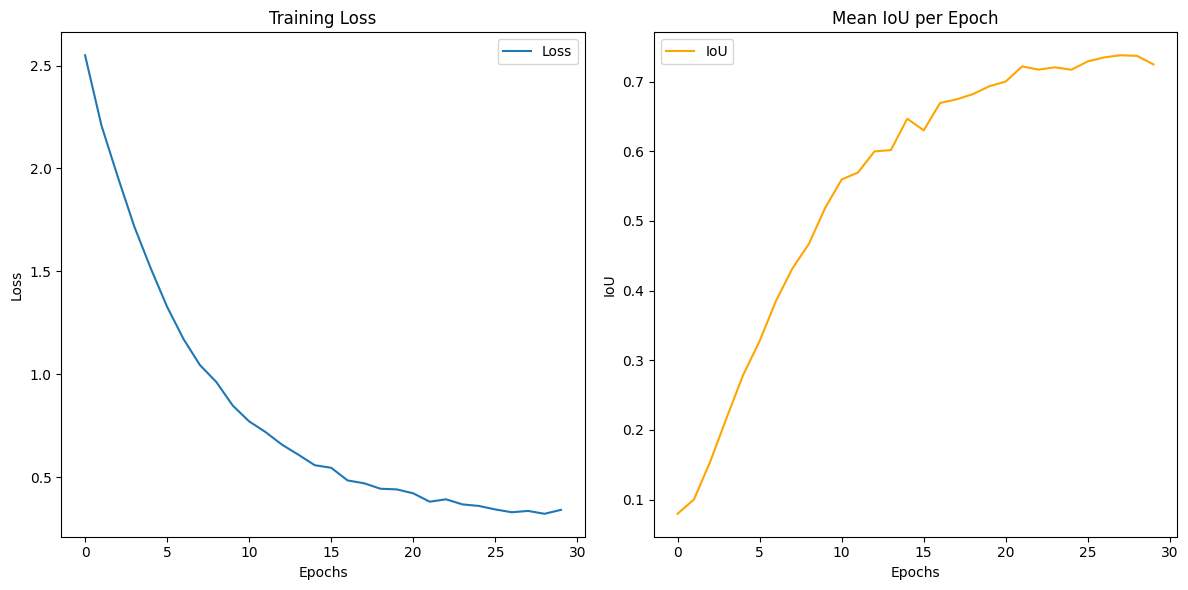

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ –º–æ–¥–µ–ª—å —Ç–µ–ø–µ—Ä—å –≤—ã–¥–∞—ë—Ç [B, 1, H, W] –±–µ–∑ softmax, –∞ –ø—Ä–æ—Å—Ç–æ –ª–æ–≥–∏—Ç—ã
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} —Ä–∞–∑–º–æ—Ä–æ–∂–µ–Ω")

# –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# –ü–æ—Ç–µ—Ä—è —Å —É—á–µ—Ç–æ–º –¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤
# pos_weight —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –≤–∫–ª–∞–¥ –∫–ª–∞—Å—Å–∞ 1 (–¥–µ—Ñ–µ–∫—Ç–æ–≤)
#criterion_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device))

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ IoU
def calculate_binary_iou(preds, labels, threshold=0.5):
    """
    –ë–∏–Ω–∞—Ä–Ω—ã–π IoU (—Ç–æ–ª—å–∫–æ –æ–¥–∏–Ω –∫–ª–∞—Å—Å).
    """
    preds = torch.sigmoid(preds) > threshold  # logits -> probabilities -> binary
    preds = preds.squeeze(1)  # [B, 1, H, W] -> [B, H, W]
    labels = labels.bool()

    intersection = (preds & labels).sum(dim=(1, 2))
    union = (preds | labels).sum(dim=(1, 2))

    iou = intersection.float() / (union.float() + 1e-6)
    return iou.cpu().numpy()

# Tversky loss
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    """
    Tversky loss for binary segmentation.
    """
    smooth = 1e-6
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    true_pos = (y_true * y_pred).sum()
    false_neg = ((1 - y_true) * y_pred).sum()
    false_pos = (y_true * (1 - y_pred)).sum()

    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

# Focal loss
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal loss for binary classification.
    """
    y_true = y_true.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)

    # Cross entropy loss
    ce_loss = F.binary_cross_entropy(torch.sigmoid(y_pred), y_true, reduction='none')

    # Focal loss modulating factor
    focal_modulating_factor = torch.pow(1 - torch.sigmoid(y_pred), gamma)

    # Apply modulating factor and weight the loss by alpha
    loss = alpha * focal_modulating_factor * ce_loss

    return loss.mean()

def combined_loss(y_true, y_pred, current_iou,
                  lambda1_base=1.0, lambda2_base=1.0,
                  pos_weight_max=10.0, pos_weight_min=5.0):
    # === –î–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–µ –≤–µ—Å–∞ –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç IoU ===
    lambda1 = 1.0 + (0.7 - current_iou) * 2.0       # 1.0 ‚Üí 2.3
    lambda2 = 1.0 + (0.7 - current_iou) * 1.5       # 1.0 ‚Üí 1.975
    gamma_t  = 1.0 + (0.7 - current_iou) * 3.0      # 1.0 ‚Üí 2.95

    # Tversky weights (–º–µ–Ω—è–µ–º –ø—Ä–∏ –ø–ª–æ—Ö–æ–º IoU –∞–∫—Ü–µ–Ω—Ç—ã –Ω–∞ FP/FN)
    alpha_t = 0.7 + (0.7 - current_iou) * 0.2       # 0.7 ‚Üí 0.83
    beta_t  = 0.3 - (0.7 - current_iou) * 0.2       # 0.3 ‚Üí 0.17

    # Focal loss focus: gamma –±–æ–ª—å—à–µ –ø—Ä–∏ –ø–ª–æ—Ö–æ–º IoU
    gamma_f = 2.0 + (0.7 - current_iou) * 1.5       # 2.0 ‚Üí 2.975
    alpha_f = 0.25 + (0.7 - current_iou) * 0.2      # 0.25 ‚Üí 0.38

    # === –î–∏–Ω–∞–º–∏—á–µ—Å–∫–æ–µ pos_weight ===
    # –ß–µ–º –Ω–∏–∂–µ IoU, —Ç–µ–º –±–æ–ª—å—à–µ –≤–µ—Å –¥–ª—è –ø–æ–∑–∏—Ç–∏–≤–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤ (–¥–µ—Ñ–µ–∫—Ç—ã)
    pos_weight = min(pos_weight_max, pos_weight_min + (1.0 - current_iou) * 5.0)  # –ù–∞–ø—Ä–∏–º–µ—Ä, –æ—Ç 5 –¥–æ 10

    # –í—Å—Ç–∞–≤–ª—è–µ–º –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–æ–µ pos_weight –≤ BCEWithLogitsLoss
    criterion_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))

    # === –°—á–∏—Ç–∞–µ–º –ø–æ—Ç–µ—Ä–∏ ===
    bce = criterion_bce(y_pred, y_true)
    focal = focal_loss(y_true, y_pred, gamma=gamma_f, alpha=alpha_f)
    tversky = tversky_loss(y_true, y_pred, alpha=alpha_t, beta=beta_t)

    loss = bce * (1 + lambda1 * focal) + lambda2 * torch.pow((1 - tversky), gamma_t)
    return loss





epochs = 30
all_losses = []
all_ious = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    iou_list = []

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device).float()  # [B, H, W] ‚Äî –∑–Ω–∞—á–µ–Ω–∏—è 0.0 –∏ 1.0

        optimizer.zero_grad()
        outputs = model(images)['out']  # [B, 1, H, W]

        # –†–∞—Å—á—ë—Ç –∫–æ–º–±–∏–Ω–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –ø–æ—Ç–µ—Ä–∏
        # –ò—Å–ø–æ–ª—å–∑—É–µ–º –∞–¥–∞–ø—Ç–∞—Ü–∏—é –Ω–∞ –ø—Ä–µ–¥—ã–¥—É—â–∏–π avg_iou
        loss = combined_loss(masks.unsqueeze(1), outputs, current_iou=all_ious[-1] if all_ious else 0.0)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        iou_batch = calculate_binary_iou(outputs, masks)
        iou_list.extend(iou_batch)

        if batch_idx % 10 == 0:
            print(f"–≠–ø–æ—Ö–∞ {epoch+1}/{epochs}, –ò—Ç–µ—Ä–∞—Ü–∏—è {batch_idx}/{len(train_loader)}, –ü–æ—Ç–µ—Ä–∏: {running_loss/(batch_idx+1):.4f}")

    avg_loss = running_loss / len(train_loader)
    avg_iou = np.nanmean(iou_list)
    all_losses.append(avg_loss)
    all_ious.append(avg_iou)

    print(f"üìâ –≠–ø–æ—Ö–∞ {epoch+1}/{epochs}, –°—Ä–µ–¥–Ω–∏–µ –ø–æ—Ç–µ—Ä–∏: {avg_loss:.4f}, –°—Ä–µ–¥–Ω–∏–π IoU: {avg_iou:.4f}")

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤–µ—Å–∞ –º–æ–¥–µ–ª–∏
torch.save(model.state_dict(), "deeplabv3_binary.pth")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(12, 6))

# –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.subplot(1, 2, 1)
plt.plot(range(epochs), all_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# –ì—Ä–∞—Ñ–∏–∫ IoU
plt.subplot(1, 2, 2)
plt.plot(range(epochs), all_ious, label='IoU', color='orange')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Mean IoU per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
BATCH_SIZE = 8
NUM_WORKERS = 2
test_dataset = MultiChannelSingleMaskDataset(test_images_path, test_masks_path, img_size=512)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS) #, drop_last=True, shuffle=True

–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']


In [18]:
from sklearn.metrics import average_precision_score

def calculate_metrics_binary(preds, labels):
    """
    –í—ã—á–∏—Å–ª—è–µ—Ç IoU, Dice –∏ AP —Ç–æ–ª—å–∫–æ –ø–æ –∫–ª–∞—Å—Å—É 1 (–¥–µ—Ñ–µ–∫—Ç).
    """
    preds = (torch.sigmoid(preds) > 0.5).float()  # Binarize: [B, 1, H, W]
    preds = preds.squeeze(1)
    labels = labels.squeeze(1)

    intersection = ((preds == 1) & (labels == 1)).sum(dim=(1, 2)).float()
    union = ((preds == 1) | (labels == 1)).sum(dim=(1, 2)).float()
    dice = (2 * intersection) / ((preds == 1).sum(dim=(1, 2)).float() + (labels == 1).sum(dim=(1, 2)).float() + 1e-8)
    iou = intersection / (union + 1e-8)

    # mAP –ø–æ –ø–∏–∫—Å–µ–ª—è–º: flatten predictions and targets
    aps = []
    for i in range(preds.shape[0]):
        pred_flat = torch.sigmoid(preds[i].unsqueeze(0)).flatten().cpu().numpy()
        label_flat = labels[i].flatten().cpu().numpy()
        if label_flat.sum() > 0:
            ap = average_precision_score(label_flat, pred_flat)
            aps.append(ap)

    return iou.mean().item(), dice.mean().item(), np.mean(aps) if aps else float('nan')


In [19]:
ious, dices, maps = [], [], []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device).float()

        outputs = model(images)['out']
        iou, dice, ap = calculate_metrics_binary(outputs, masks)

        if not np.isnan(iou):
            ious.append(iou)
        if not np.isnan(dice):
            dices.append(dice)
        if not np.isnan(ap):
            maps.append(ap)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)
mean_ap = np.mean(maps)

print(f"üìê IoU (defect): {mean_iou:.4f}")
print(f"‚ù§Ô∏è Dice (defect): {mean_dice:.4f}")
print(f"üèÖ mAP (defect): {mean_ap:.4f}")


üìê IoU (defect): 0.5171
‚ù§Ô∏è Dice (defect): 0.6587
üèÖ mAP (defect): 0.5039


In [20]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

def apply_mask(image, mask, color=(255, 0, 0), alpha=0.5):
    """–ù–∞–∫–ª–∞–¥—ã–≤–∞–µ—Ç –º–∞—Å–∫—É –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —Å –ø—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç—å—é."""
    if len(mask.shape) == 3:
        mask = mask.squeeze()  # [1, H, W] ‚Üí [H, W]
    
    colored_mask = np.zeros_like(image)
    for i in range(3):
        colored_mask[:, :, i] = mask * color[i]
    
    overlay = cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)
    return overlay

def visualize_predictions(test_loader, predictions, num_samples=10):
    predictions = [pred.squeeze().cpu().numpy() if torch.is_tensor(pred) else pred for pred in predictions]
    samples = random.sample(range(len(predictions)), num_samples)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]
        mask = mask.numpy().squeeze()
        pred_mask = predictions[idx]

        # Ensure masks are 2D
        if pred_mask.ndim > 2:
            pred_mask = pred_mask.squeeze()
        if mask.ndim > 2:
            mask = mask.squeeze()

        # Binarize predicted mask (assuming values in [0, 1])
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        mask_binary = (mask > 0.5).astype(np.uint8)

        # Apply mask overlays
        overlay_pred = apply_mask((image * 255).astype(np.uint8), pred_binary, color=(255, 255, 0), alpha=0.5)
        overlay_gt = apply_mask((image * 255).astype(np.uint8), mask_binary, color=(100, 238, 100), alpha=0.5)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Original")
        
        axes[i, 1].imshow(overlay_gt)
        axes[i, 1].set_title("Ground Truth Overlay")
        
        axes[i, 2].imshow(overlay_pred)
        axes[i, 2].set_title("Predicted Overlay")
        
        axes[i, 3].imshow(pred_binary, cmap='jet')
        axes[i, 3].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


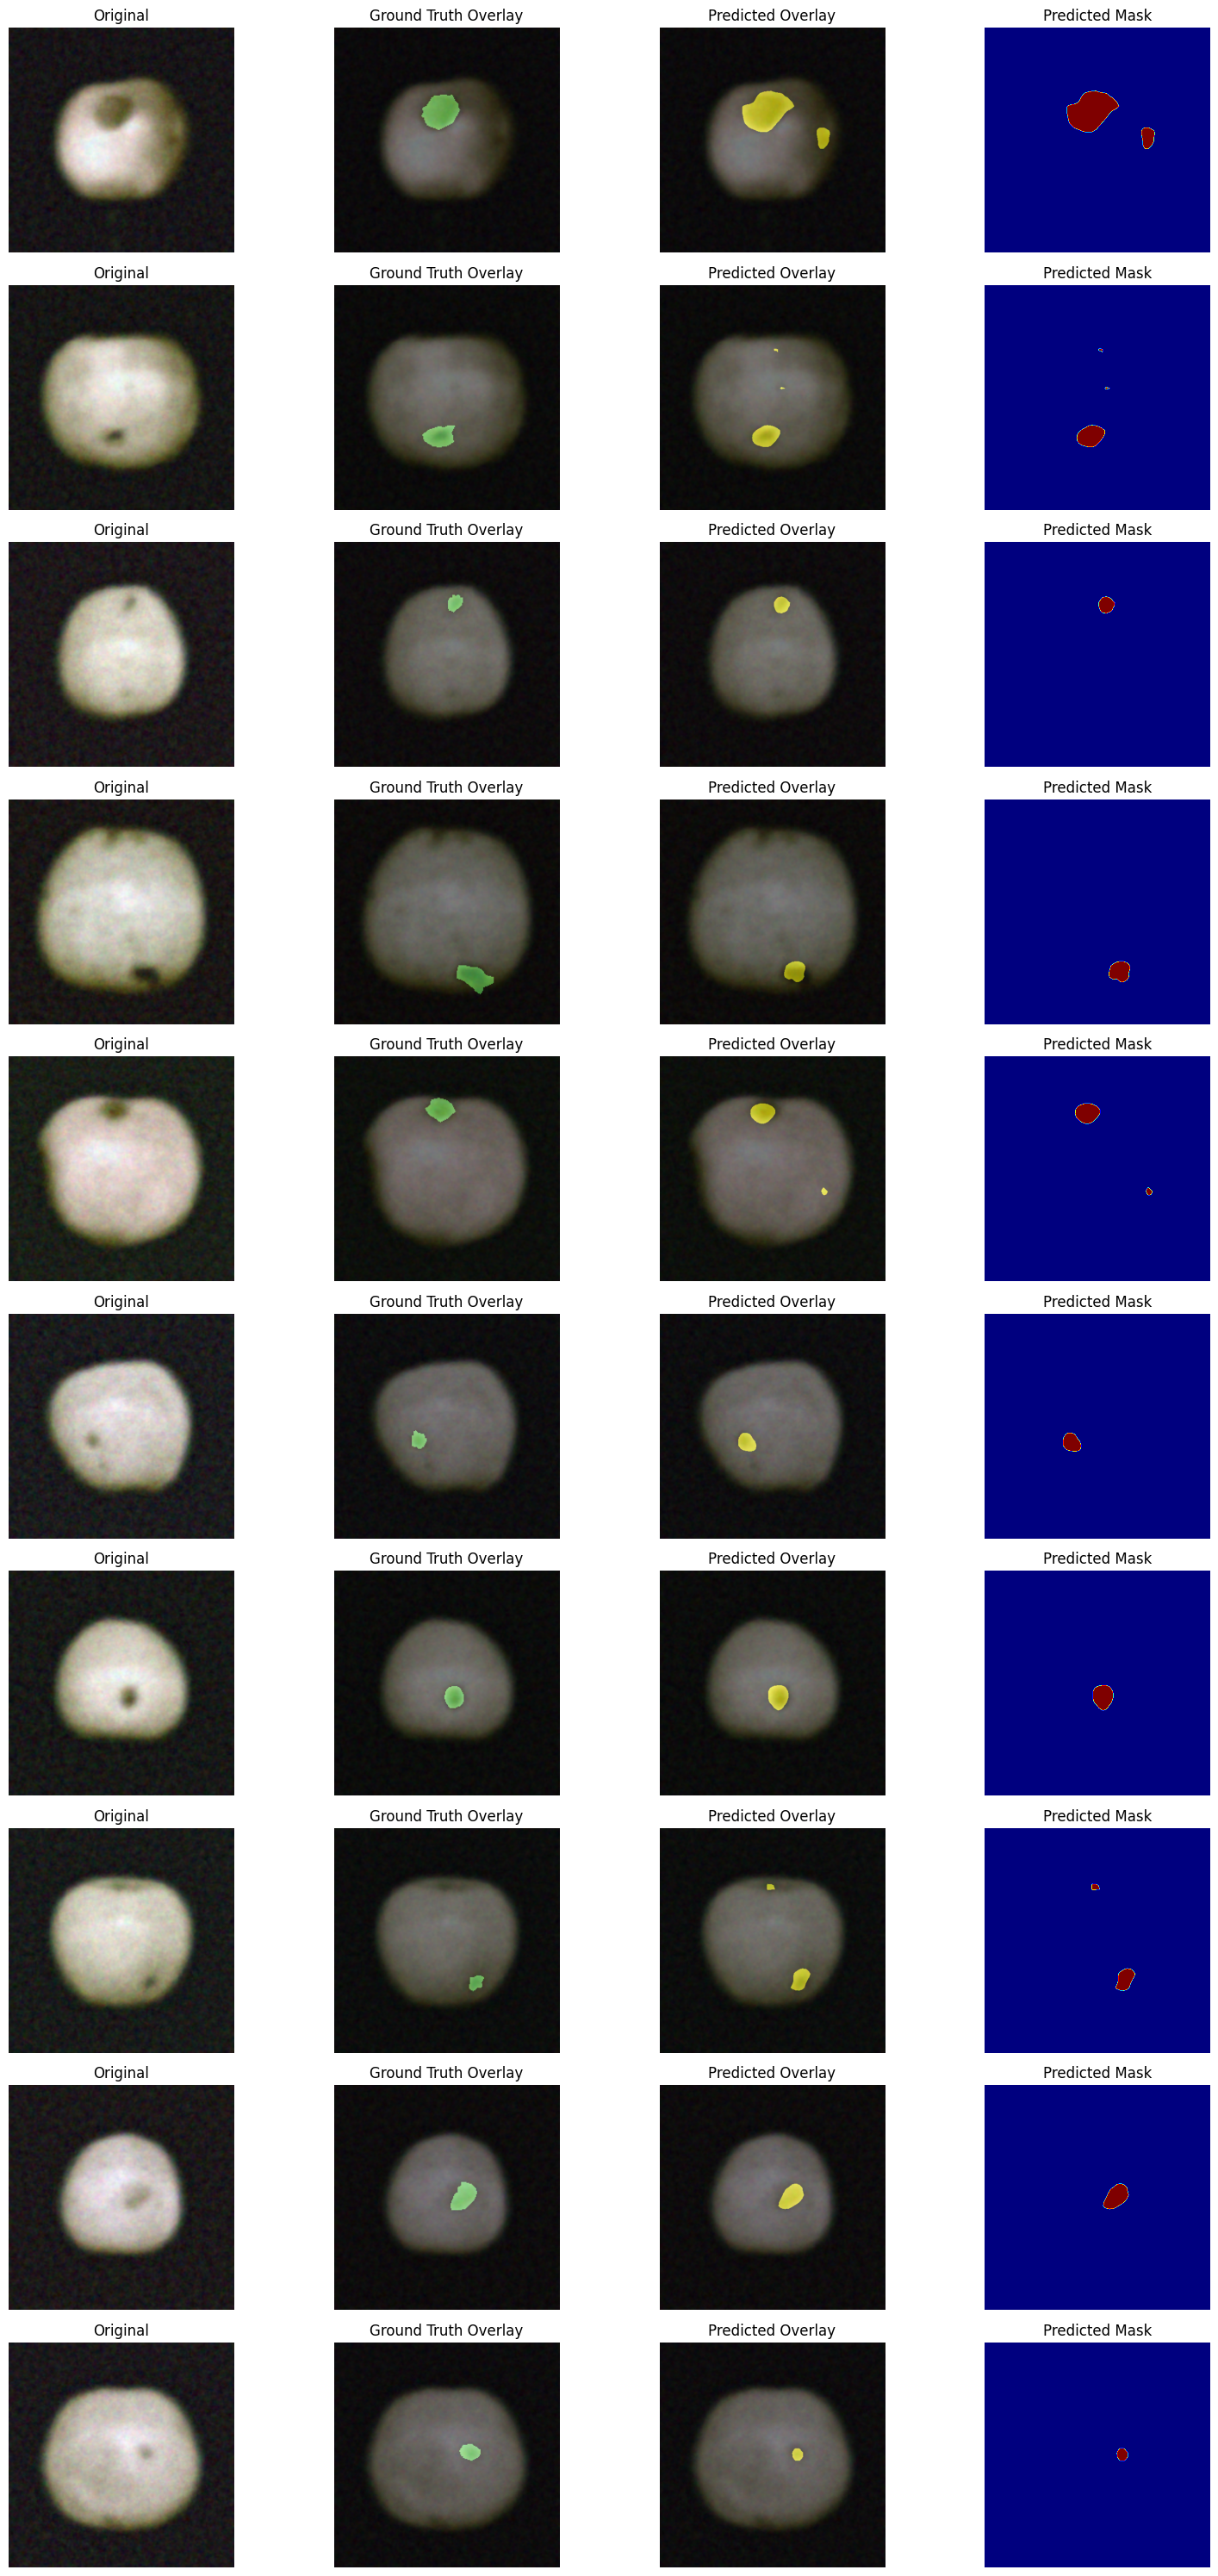

In [21]:
# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –º–∞—Å–æ–∫ –¥–ª—è –≤—Å–µ–≥–æ test_loader
model.eval()
predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)['out']
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu()
        predictions.extend(preds)

visualize_predictions(test_loader, predictions, num_samples=10)


In [22]:
import random
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate

def generate_random_tta():
    return Compose([
        HorizontalFlip(p=random.choice([0.0, 1.0])),
        VerticalFlip(p=random.choice([0.0, 1.0])),
    ])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [23]:
tta_datasets = []

for i in range(5):
    tta_transform = generate_random_tta()
    dataset = MultiChannelSingleMaskDataset(
        test_images_path,
        test_masks_path,
        img_size=512,
        transform=tta_transform
    )
    tta_datasets.append(dataset)

–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π: ['004', '009', '010', '015', '016', '018', '019', '020', '022', '023', '025', '027', '028', '029', '031', '032', '033', '352', '356', '358', '360', '361', '362', '363', '364', '365', '366', '367', '369', '373', '376', '377', '378', '379', '380', '381']
–ù–∞–π–¥–µ–Ω—ã —Å–ª–µ–¥—É—é—â–∏–µ ID –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–

In [24]:
from torch.utils.data import DataLoader
import numpy as np

all_ious, all_dices, all_maps = [], [], []

model.eval()
with torch.no_grad():
    for idx, dataset in enumerate(tta_datasets):
        print(f"üîÑ TTA iteration {idx + 1}/10")
        loader = DataLoader(dataset, batch_size=4, num_workers=4)

        ious, dices, maps = [], [], []

        for images, masks in loader:
            if images is None or masks is None:
                continue  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º –±–∏—Ç—ã–µ –¥–∞–Ω–Ω—ã–µ
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)['out']
            iou, dice, ap = calculate_metrics_binary(outputs, masks)

            if not np.isnan(iou):
                ious.append(iou)
            if not np.isnan(dice):
                dices.append(dice)
            if not np.isnan(ap):
                maps.append(ap)

        all_ious.append(np.mean(ious))
        all_dices.append(np.mean(dices))
        all_maps.append(np.mean(maps))

# üìä –§–∏–Ω–∞–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞
mean_iou = np.mean(all_ious)
mean_dice = np.mean(all_dices)
mean_ap = np.mean(all_maps)

std_iou = np.std(all_ious)
std_dice = np.std(all_dices)
std_ap = np.std(all_maps)

print("\nüìà Aggregated metrics over 10 TTA runs:")
print(f"üìê IoU (defect): {mean_iou:.4f} ¬± {std_iou:.4f}")
print(f"‚ù§Ô∏è Dice (defect): {mean_dice:.4f} ¬± {std_dice:.4f}")
print(f"üèÖ mAP (defect): {mean_ap:.4f} ¬± {std_ap:.4f}")


üîÑ TTA iteration 1/10
üîÑ TTA iteration 2/10
üîÑ TTA iteration 3/10
üîÑ TTA iteration 4/10
üîÑ TTA iteration 5/10

üìà Aggregated metrics over 10 TTA runs:
üìê IoU (defect): 0.4897 ¬± 0.0277
‚ù§Ô∏è Dice (defect): 0.6277 ¬± 0.0312
üèÖ mAP (defect): 0.4778 ¬± 0.0275
